In [1]:
from numpy import mean, std
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# define date range
start_date = '2005-01-22'
end_date  = datetime.today().strftime('%Y-%m-%d')


In [3]:
diction = {'Gold': 'GC=F', 'US treas bonds':'QLTA', '10y': '^TNX','sp500': 'SPY'}

for i in diction:
    print(diction[i])

GC=F
QLTA
^TNX
SPY


In [4]:
# retrieve markets


data = yf.download(['GC=F', 'QLTA', '^TNX', 'SPY'], start_date, end_date)
print(data)

[*********************100%***********************]  4 of 4 completed
              Adj Close                                      Close             \
                   GC=F       QLTA         SPY   ^TNX         GC=F       QLTA   
Date                                                                            
2005-01-24   426.899994        NaN   82.248016  4.122   426.899994        NaN   
2005-01-25   422.000000        NaN   82.480896  4.189   422.000000        NaN   
2005-01-26   426.899994        NaN   82.727875  4.192   426.899994        NaN   
2005-01-27   426.299988        NaN   82.868988  4.207   426.299988        NaN   
2005-01-28   425.799988        NaN   82.868988  4.138   425.799988        NaN   
...                 ...        ...         ...    ...          ...        ...   
2023-02-28  1828.900024  46.374001  396.260010  3.916  1828.900024  46.500000   
2023-03-01  1837.699951  46.150002  394.739990  3.994  1837.699951  46.150002   
2023-03-02  1833.500000  46.099998  397.

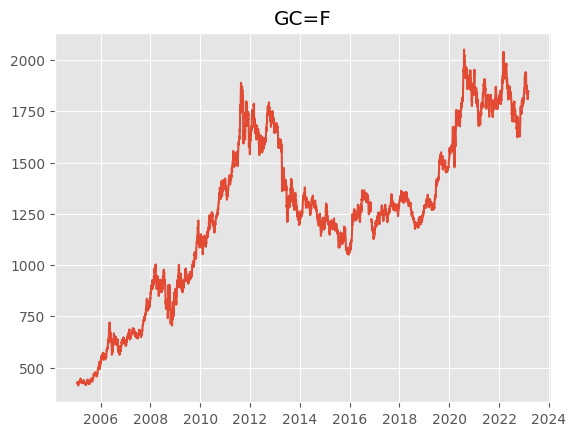

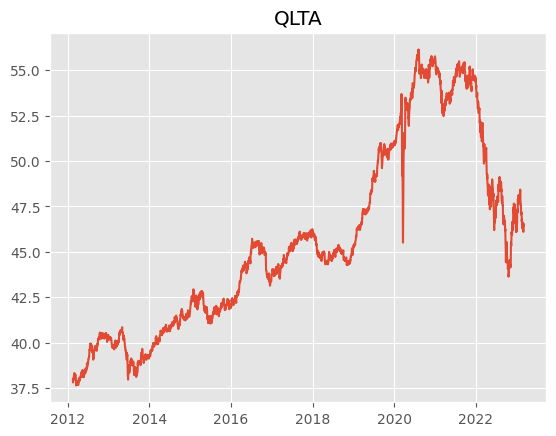

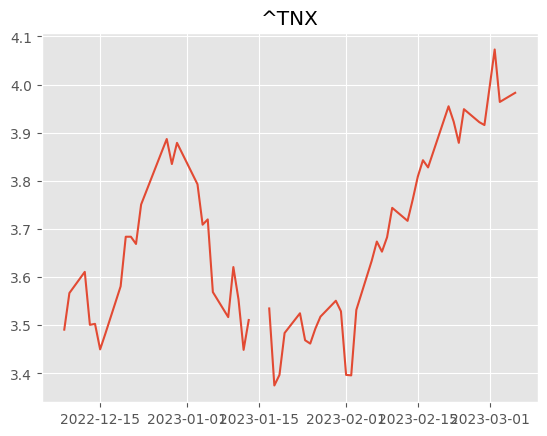

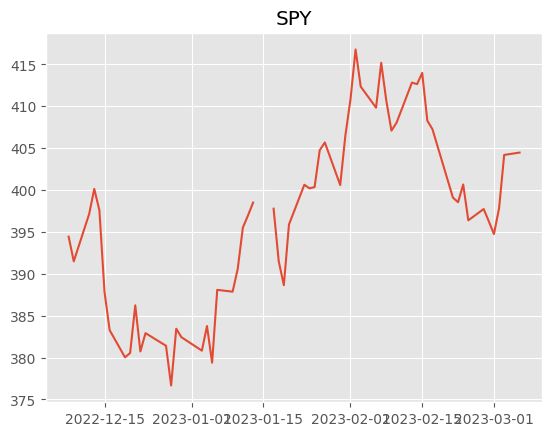

In [5]:
plt.plot(data[('Adj Close', 'GC=F')])
plt.title('GC=F')
plt.show()

plt.plot(data[('Adj Close', 'QLTA')])
plt.title('QLTA')
plt.show()

plt.plot(data[('Adj Close', '^TNX')][-60:])
plt.title('^TNX')
plt.show()

plt.plot(data[('Adj Close', 'SPY')][-60:])
plt.title('SPY')
plt.show()

In [6]:
print(data.columns)
print(data['Adj Close'].head())

MultiIndex([('Adj Close', 'GC=F'),
            ('Adj Close', 'QLTA'),
            ('Adj Close',  'SPY'),
            ('Adj Close', '^TNX'),
            (    'Close', 'GC=F'),
            (    'Close', 'QLTA'),
            (    'Close',  'SPY'),
            (    'Close', '^TNX'),
            (     'High', 'GC=F'),
            (     'High', 'QLTA'),
            (     'High',  'SPY'),
            (     'High', '^TNX'),
            (      'Low', 'GC=F'),
            (      'Low', 'QLTA'),
            (      'Low',  'SPY'),
            (      'Low', '^TNX'),
            (     'Open', 'GC=F'),
            (     'Open', 'QLTA'),
            (     'Open',  'SPY'),
            (     'Open', '^TNX'),
            (   'Volume', 'GC=F'),
            (   'Volume', 'QLTA'),
            (   'Volume',  'SPY'),
            (   'Volume', '^TNX')],
           )
                  GC=F  QLTA        SPY   ^TNX
Date                                          
2005-01-24  426.899994   NaN  82.248016  4.122
2005-

14
14
14
14


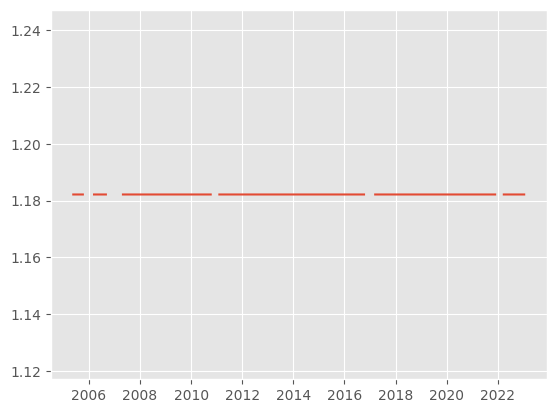

In [43]:
def rs_ratio(prices_df, benchmark, w=14):
    
    """
    Function that returns dataframe with relative strength ratio for each symbol
    """

    ratio_df = pd.DataFrame()
    
    def ratio_funct(window, column, benchmark):

        rs = (column[-len(window):] / benchmark[-len(window):]) * 100
        rs_ratio = rs.rolling(w).mean()
        rel_ratio = (rs_ratio - rs_ratio.mean()) / rs_ratio.std()

        return rel_ratio[-1]

    for column in prices_df[:1]:
        print(w)
        ratio_df[f"{column}_ratio"] = prices_df[column].rolling(window = w*6).apply(ratio_funct, args=(prices_df[column], benchmark))

    ratio_df.dropna(axis=0, how="all", inplace=True)

    return ratio_df


ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])
#plt.plot(data[('Adj Close', '^TNX')])
plt.plot(ratio_df['^TNX_ratio'])

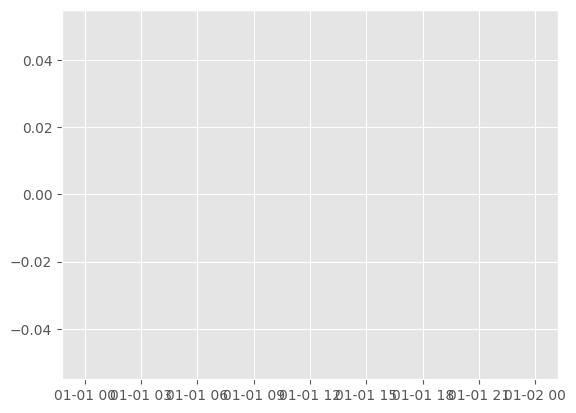

In [40]:
plt.plot(ratio_df['^TNX_ratio'])

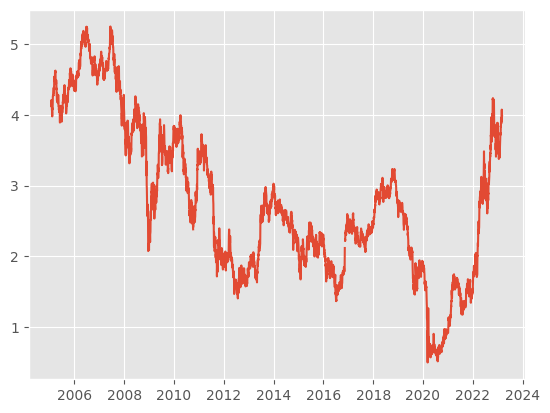

In [39]:
plt.plot(data[('Adj Close', '^TNX')])


In [16]:

def rs_ratio(prices_df, benchmark, window=14):
    """
    Function to return dataframe with relative strength ratio for each symbol
    """
    
    ratio_df = pd.DataFrame()
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        rs = (prices_df[column][-window*4:] / benchmark[-window*4:]) * 100
        rs_ratio = rs.rolling(window).mean()
        #rel_ratio = 100 + ((rs_ratio - rs_ratio.mean()) / rs_ratio.std() + 1)
        
        rel_ratio = 100 + ((rs_ratio - rs_ratio.mean()) / rs_ratio.std())

        ratio_df[f'{column}_ratio'] = rel_ratio
        
    ratio_df.dropna(axis=0, how='all', inplace=True)
    
    return ratio_df

ratio_df = rs_ratio(data['Adj Close'], data[('Adj Close', 'SPY')])
print(ratio_df)

            GC=F_ratio  QLTA_ratio  SPY_ratio  ^TNX_ratio
Date                                                     
2023-01-03   99.936383  101.077832        NaN  101.105680
2023-01-04  100.129694  101.156006        NaN  101.270224
2023-01-05  100.319871  101.241216        NaN  101.449015
2023-01-06  100.465100  101.216179        NaN  101.503188
2023-01-09  100.568685  101.173031        NaN  101.500083
2023-01-10  100.626148  101.092185        NaN  101.472693
2023-01-11  100.604952  101.025049        NaN  101.347690
2023-01-12  100.653113  101.011222        NaN  101.194915
2023-01-13  100.732015  100.926811        NaN  101.046339
2023-01-16  100.806291  100.872251        NaN  100.876045
2023-01-17  100.830209  100.837765        NaN  100.654285
2023-01-18  100.872622  100.853881        NaN  100.348898
2023-01-19  101.004114  100.933419        NaN  100.122237
2023-01-20  101.074852  100.941208        NaN   99.880913
2023-01-23  101.061266  100.865058        NaN   99.672117
2023-01-24  10

In [17]:
def rs_momentum(prices_df, benchmark, window=14):
    """
    Function to return dataframe with relative strength momentum for each symbol
    """
    
    momentum_df = pd.DataFrame()
    
    benchmark = benchmark.interpolate()
    benchmark = benchmark.interpolate(limit_direction='backward')
    prices_df = prices_df.interpolate()
    prices_df = prices_df.interpolate(limit_direction='backward')
    
    for column in prices_df:
        
        rs = (prices_df[column][-window*4:] / benchmark[-window*4:]) * 100
        
        rs_ratio = rs.rolling(window).mean()
        
        rs_momentum = rs_ratio - rs_ratio.shift(5)
        
        #rel_momentum = 100 + ((rs_momentum - rs_momentum.mean()) / rs_momentum.std() + 1)
        rel_momentum = 100 + ((rs_momentum - rs_momentum.mean()) / rs_momentum.std())
        
        momentum_df[f'{column}_momentum'] = rel_momentum
        
    momentum_df.dropna(axis=0, how='all', inplace=True)
    
    return momentum_df

momentum_df = rs_momentum(data['Adj Close'], data[('Adj Close', 'SPY')])
print(momentum_df)

            GC=F_momentum  QLTA_momentum  SPY_momentum  ^TNX_momentum
Date                                                                 
2023-01-10     101.707762     101.185638           NaN     100.544159
2023-01-11     101.308547     100.683430           NaN     100.165756
2023-01-12     101.044240     100.341150           NaN      99.732439
2023-01-13     100.920800     100.135945           NaN      99.467472
2023-01-16     100.866253     100.096504           NaN      99.248977
2023-01-17     100.803823     100.256727           NaN      98.994958
2023-01-18     100.922203     100.544457           NaN      98.759219
2023-01-19     101.077292     100.867136           NaN      98.662658
2023-01-20     101.062096     101.185791           NaN      98.541447
2023-01-23     100.898576     101.111171           NaN      98.491130
2023-01-24     100.859331     101.054567           NaN      98.546772
2023-01-25     100.795587     100.708227           NaN      98.673805
2023-01-26     100.5

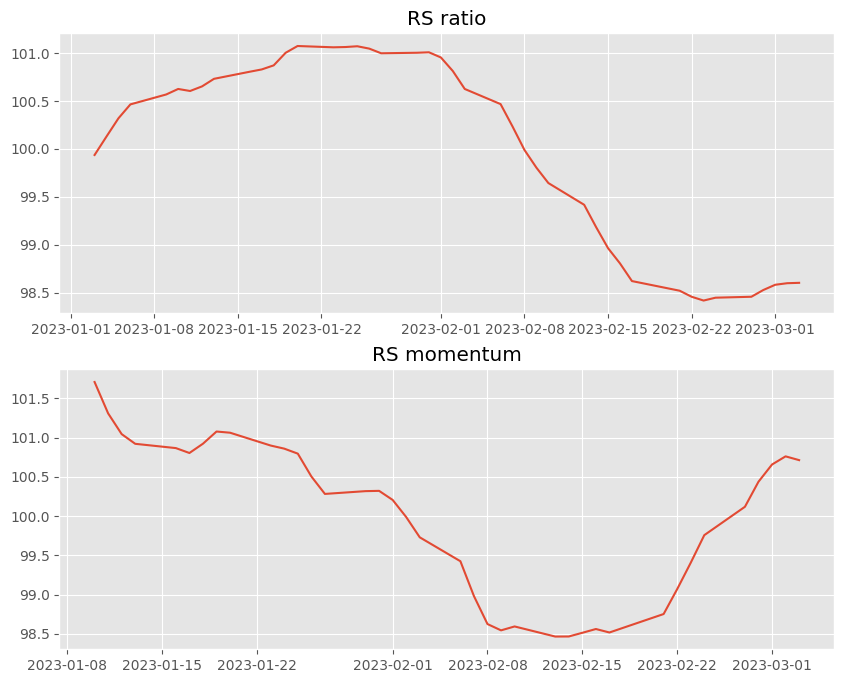

In [18]:
def visualize_rs(symbol:str):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(ratio_df[f'{symbol}_ratio'], label=ratio_df.columns)
    ax[0].set_title('RS ratio')
    #ax[0].legend()

    ax[1].plot(momentum_df[f'{symbol}_momentum'], label=momentum_df.columns)
    ax[1].set_title('RS momentum')
    #ax[1].legend()
    plt.show()
    
visualize_rs('GC=F')

In [19]:
# merge rs ratio and momentum data
df = pd.merge(ratio_df, momentum_df, left_on=ratio_df.index, right_on=momentum_df.index).set_index('key_0')

print(df[-40:])

            GC=F_ratio  QLTA_ratio  SPY_ratio  ^TNX_ratio  GC=F_momentum  \
key_0                                                                      
2023-01-10  100.626148  101.092185        NaN  101.472693     101.707762   
2023-01-11  100.604952  101.025049        NaN  101.347690     101.308547   
2023-01-12  100.653113  101.011222        NaN  101.194915     101.044240   
2023-01-13  100.732015  100.926811        NaN  101.046339     100.920800   
2023-01-16  100.806291  100.872251        NaN  100.876045     100.866253   
2023-01-17  100.830209  100.837765        NaN  100.654285     100.803823   
2023-01-18  100.872622  100.853881        NaN  100.348898     100.922203   
2023-01-19  101.004114  100.933419        NaN  100.122237     101.077292   
2023-01-20  101.074852  100.941208        NaN   99.880913     101.062096   
2023-01-23  101.061266  100.865058        NaN   99.672117     100.898576   
2023-01-24  101.064096  100.814193        NaN   99.492933     100.859331   
2023-01-25  

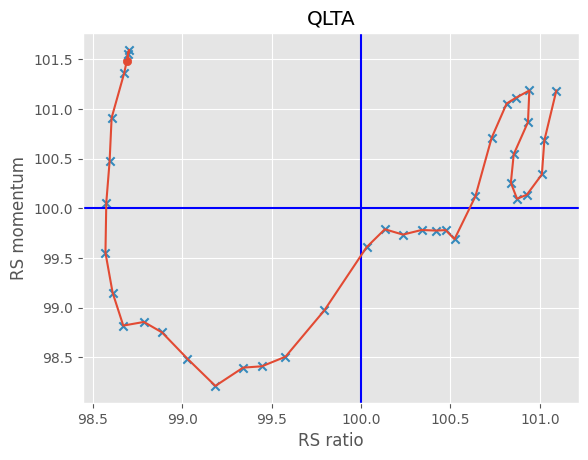

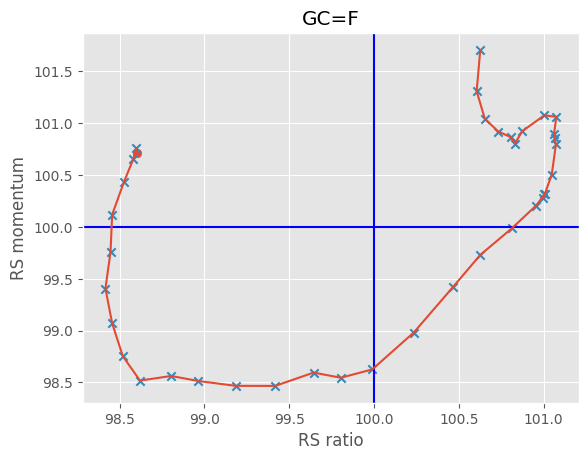

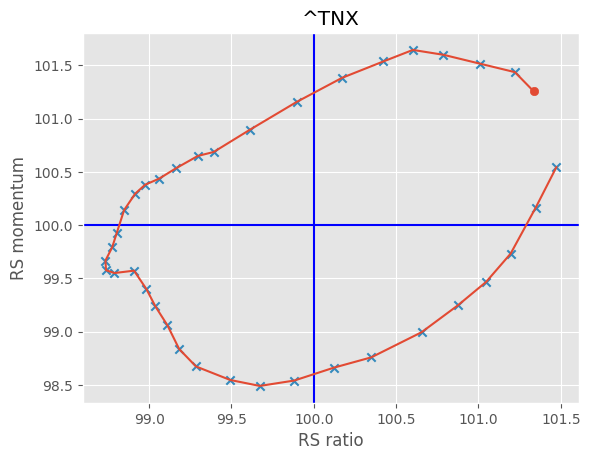

In [20]:
def rrg_plot(df, symbol, period = 20):
    """
    Method to visualize RRG plot for one market/symbol. The benchmark is SPY
    """
    df = df.copy()
    df =df.iloc[-period:]
    
    last = df.iloc[-1]    
    others = df.iloc[:-1]    

    plt.axvline(x = 100, color = 'b')
    plt.axhline(y = 100, color = 'b')

    plt.plot(df[f'{symbol}_ratio'], df[f'{symbol}_momentum'])
    plt.scatter(last[f'{symbol}_ratio'], last[f'{symbol}_momentum'], marker='o')
    plt.scatter(others[f'{symbol}_ratio'], others[f'{symbol}_momentum'], marker='x')

    plt.title(symbol)
    plt.xlabel("RS ratio")
    plt.ylabel("RS momentum")

    plt.show()
    

rrg_plot(df, 'QLTA', 40)
rrg_plot(df, 'GC=F', 40)
rrg_plot(df, '^TNX', 40)


